# Импорт библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import nibabel as nib
import torch
import torchvision.transforms as transforms
import cv2
from PIL import Image
from sklearn.linear_model import LinearRegression
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve
import scipy.signal as signal
import random
from sklearn.metrics import r2_score

# Задание окружения

In [2]:
figures = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "figures")

# Работа с данными

## Видеоряд

In [3]:
video_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "src", "Film stimulus.mp4")

In [4]:
def video_to_frames():
    videocap = cv2.VideoCapture(video_path)
    success, frame = videocap.read()
    count = 1
    while success:
        cv2.imwrite(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),
                                "src", "frames", f"frame_{count}.jpg"), frame)    
        success, frame = videocap.read()
        count += 1

In [5]:
#video_to_frames()

In [6]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True, verbose=False)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(2048, 2048)

c:\Users\kisnikser\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\kisnikser\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
def frames_to_tensors():
    for i in range(1, 9751):
        frame_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "src", "frames", f"frame_{i}.jpg")
        frame = Image.open(frame_path)
        frame_tensor = preprocess(frame)
        frame_tensor = frame_tensor.unsqueeze(0)
        yield frame_tensor

In [9]:
def tensors_to_vectors():
    for frame_tensor in frames_to_tensors():
        # передача картинки в модель и получение выходных данных
        with torch.no_grad():
            output = model(frame_tensor)
        # преобразование выходных данных в вектор
        vector = output.numpy().flatten()
        yield vector

In [10]:
#vector_list = [vector for vector in tensors_to_vectors()]
#np.save("vector_list", vector_list)
vector_list = np.load(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "src", "vector_list.npy"))

## Снимки фМРТ

In [11]:
subs_with_fmri = ['04', '07', '08', '09', '11', '13', '14', '15', '16', '18',\
                  '22', '24', '27', '28', '29', '31', '35', '41', '43', '44',\
                  '45', '46', '47', '51', '52', '53', '55', '56', '60', '62']

In [12]:
def subs_to_tensors():
    for sub in subs_with_fmri:
        sub_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "src", "ds003688-download", f"sub-{sub}",\
                                "ses-mri3t", "func", f"sub-{sub}_ses-mri3t_task-film_run-1_bold.nii.gz")
        sub_scan = nib.load(sub_path)
        sub_data = sub_scan.get_fdata()
        sub_tensor = torch.tensor(sub_data)
        yield sub_tensor
        

In [13]:
def get_sub_tensor(nsub: str):
    for sub, sub_tensor in zip(subs_with_fmri, subs_to_tensors()):
        if nsub != sub:
            continue
        else:
            return sub_tensor

In [14]:
def scans_to_tensors(nsub: str):
    sub_tensor = get_sub_tensor(nsub)
    for i in range(sub_tensor.shape[3]):
        scan_tensor = sub_tensor[:, :, :, i]
        yield scan_tensor.numpy()

# Построение линейной модели

## Рассмотрение конкретного испытуемого

In [32]:
# ------------------------------------------------
# Восстановление снимка фМРТ по одному изображению
# ------------------------------------------------
# dt - гиперпараметр, время задержки
# sub - номер испытуемого
# coef - во сколько раз сжимается снимок фМРТ
# alpha - коэффициент регуляризации
# -------------------------------------------
def sub_linear_prediction(dt=4, sub='04', coef=8, alpha=0):
    nu = 25 # частота видео
    mu = 641. / 390. # частота снимков фМРТ
    m, n, k = 40, 64, 64 # размерности снимка фМРТ до сжатия
    d = 2048 # длина вектора признакового описания изображения
    N = 641 - int(mu * dt) # N - количество снимков fMRI

    # (номер изображения, номер снимка)
    pairs = [(int(m * nu / mu), int(mu * dt + m)) for m in range(N)]

    # тензор снимка фМРТ
    sub_tensor = get_sub_tensor(sub)
    
    # сжатие снимка фМРТ
    if (coef > 1):
        maxpool = torch.nn.MaxPool3d(kernel_size=coef, stride=coef)
        input_tensor = sub_tensor.permute(3, 0, 1, 2)
        output_tensor = maxpool(input_tensor).permute(1, 2, 3, 0)
    else:
        output_tensor = sub_tensor

    d1, d2, d3, d4 = output_tensor.shape

    # список тензоров снимков фМРТ
    scans_list = [output_tensor[:, :, :, i] for i in range(d4)]

    # список снимков фМРТ, развернутых в векторы
    voxels = [scan.reshape(d1 * d2 * d3).numpy() for scan in scans_list]

    # (изображение, снимок)
    data = [(vector_list[n], voxels[k]) for n, k in pairs]

    # train, test
    l = int(0.7 * d4) # размер обучающей выборки
    train, test = data[:l], data[l:]

    # preprocessing
    def preprocess(v):
        return (v - v.min()) / (v.max() - v.min())
        
    train = [(pair[0], preprocess(pair[1])) for pair in train]
    test = [(pair[0], preprocess(pair[1])) for pair in test]

    # матрица весов модели
    W = []

    X_train = np.array([pair[0] for pair in train])
    Y_train = np.array([pair[1] for pair in train]).T
    X_test = np.array([pair[0] for pair in test])
    Y_test = np.array([pair[1] for pair in test]).T

    if (alpha > 0):
        A = np.linalg.inv(X_train.T @ X_train + alpha * np.identity(X_train.shape[1])) @ X_train.T
    else:
        A = np.linalg.pinv(X_train)
    
    for i in range(d1 * d2 * d3):
        Y_train_vector = Y_train[i]
        w = A @ Y_train_vector
        W.append(w)
        
    # w будут строками
    W = np.array(W)

    Y_train_predicted = W @ X_train.T
    Y_test_predicted = W @ X_test.T
    
    # усреднение по всем столбцам (снимкам фМРТ)
    def MSE(A):
        m, n = A.shape
        return 1 / n * np.linalg.norm(A, "fro") ** 2
    
    MSE_train = MSE(Y_train_predicted - Y_train)
    MSE_test = MSE(Y_test_predicted - Y_test)

    # сохранение выхода в файл
    output = np.array([MSE_train, MSE_test, Y_test, Y_test_predicted, d1, d2, d3], dtype=object)
    folder_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "src", 'subs', f"sub-{sub}")
    output_name = f"output-{dt}-{sub}-{coef}"
    if (alpha > 0):
        output_name = output_name + f"-reg-{alpha}"
    output_name = os.path.join(folder_path, output_name)
    np.save(output_name, output, allow_pickle=True)

    return output

In [87]:
def get_model_result(dt=4, sub='04', coef=8, alpha=0):
    output_name = f"output-{dt}-{sub}-{coef}"
    if (alpha > 0):
        output_name = output_name + f"-reg-{alpha}.npy"
    folder_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "src", 'subs', f"sub-{sub}")
    output_name = os.path.join(folder_path, output_name)
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
    if not os.path.exists(output_name):
        output = sub_linear_prediction(dt, sub, coef, alpha)
    else:
        output = np.load(output_name, allow_pickle=True)
        
    return output

In [88]:
%%time
output = get_model_result(dt=4, sub='04', coef=8, alpha=100)
MSE_train, MSE_test, Y_test, Y_test_predicted, d1, d2, d3 = output
print(f"MSE_train = {MSE_train:.2f}, MSE_test = {MSE_test:.2f}")

MSE_train = 0.17, MSE_test = 0.63
CPU times: total: 15.6 ms
Wall time: 28 ms


## Зависимость MSE на тестовой выборке от гиперпараметра $\Delta t$

In [27]:
t = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]
mse_matrix = []

for sub in subs_with_fmri:
    mse = []
    deviation = []

    for dt in t:
        output = get_model_result(dt=dt, sub=sub, compression=True, coef=8, train_size=0.7)
        MSE_train, MSE_test, Y_test, Y_test_predicted, d1, d2, d3 = output
        deviation.append(abs(Y_test - Y_test_predicted).max())
        mse.append(MSE_test)
    
    mse_matrix.append(mse)

mse_matrix = np.array(mse_matrix)

In [31]:
mse_means = np.array([vector.mean() for vector in mse_matrix.T])
mse_stds = np.array([vector.std() for vector in mse_matrix.T])

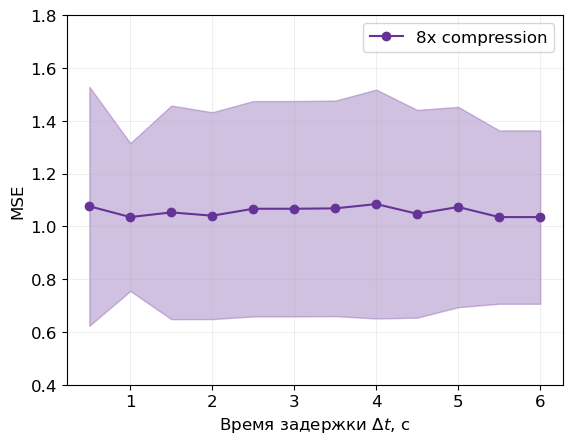

In [41]:
plt.rcParams.update({'font.size': 12})
plt.rc("font", family='sans-serif')

plt.plot(t, mse_means, marker='o', color="rebeccapurple", label="8x compression")
plt.fill_between(t, mse_means - mse_stds, mse_means + mse_stds, color="rebeccapurple", alpha = 0.3)
plt.xlabel("Время задержки $\Delta t$, с")
plt.ylabel("MSE")
plt.ylim(0.4, 1.8)
plt.legend()
plt.grid(alpha=0.2)

plt.savefig(os.path.join(figures, "subs_MSE_dt.pdf"), bbox_inches="tight")

## Срезы истинного и восстановленного снимков

In [46]:
def get_scan_slices(delta=False, dt=4, sub='04', coef=8, alpha=0, scan_number=0, dim=0, slice_number=0):
    if delta:
        output = get_delta_model_result(dt, sub, coef, alpha)
        MSE_train, MSE_test, Y_test_0, Y_test, Y_test_predicted, deltaY_test_predicted, d1, d2, d3 = output
    else:
        output = get_model_result(dt, sub, coef, alpha)
        MSE_train, MSE_test, Y_test, Y_test_predicted, d1, d2, d3 = output
    
    # original fmri scan 
    fmri_test_vector = Y_test.T[scan_number]
    fmri_test = fmri_test_vector.reshape((d1, d2, d3))

    # predicted fmri scan
    fmri_predicted_vector = Y_test_predicted.T[scan_number]
    fmri_predicted = fmri_predicted_vector.reshape((d1, d2, d3))

    # difference between them
    fmri_delta = abs(fmri_test - fmri_predicted)
    
    slices = [':', ':', ':']
    if dim == 0:
        slices[0] = slice_number
        slice_orig_image = fmri_test[slice_number, :, :].T
        orig_name = f"sub-{dt}-{sub}-{coef}-{alpha}-{slice_number}-_-_-orig.pdf"
        slice_pred_image = fmri_predicted[slice_number, :, :].T
        pred_name = f"sub-{dt}-{sub}-{coef}-{alpha}-{slice_number}-_-_-pred.pdf"
        slice_delta_image = fmri_delta[slice_number, :, :].T
        delta_name = f"sub-{dt}-{sub}-{coef}-{alpha}-{slice_number}-_-_-delta.pdf"
    elif dim == 1:
        slices[1] = slice_number,
        slice_orig_image = fmri_test[:, slice_number, :].T
        orig_name = f"sub-{dt}-{sub}-{coef}-{alpha}-_-{slice_number}-_-orig.pdf"
        slice_pred_image = fmri_test[:, slice_number, :].T
        pred_name = f"sub-{dt}-{sub}-{coef}-{alpha}-_-{slice_number}-_-pred.pdf"
        slice_delta_image = fmri_delta[:, slice_number, :].T
        delta_name = f"sub-{dt}-{sub}-{coef}-{alpha}-_-{slice_number}-_-delta.pdf"
    elif dim == 2:
        slices[2] = slice_number
        slice_orig_image = fmri_test[:, :, slice_number].T
        orig_name = f"sub-{dt}-{sub}-{coef}-{alpha}-_-_-{slice_number}-orig.pdf"
        slice_pred_image = fmri_test[:, :, slice_number].T
        pred_name = f"sub-{dt}-{sub}-{coef}-{alpha}-_-_-{slice_number}-pred.pdf"
        slice_delta_image = fmri_delta[:, :, slice_number].T
        delta_name = f"sub-{dt}-{sub}-{coef}-{alpha}-_-_-{slice_number}-delta.pdf"
    
    figures = "figures_delta" if delta else "figures"

    folder_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), figures, f"sub-{dt}-{sub}-{coef}")
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    os.chmod(folder_path, 0o400)
    
    print("INFORMATION:")
    print(f"dt = {dt}, sub = {sub}, coef = {coef}, slices = {slices}\n")

    print("ORIGINAL")
    plt.imshow(slice_orig_image, cmap="gray", origin="lower")
    plt.colorbar()
    plt.savefig(
            os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), figures, f"sub-{dt}-{sub}-{coef}", orig_name),
            bbox_inches="tight")
    plt.show()
        
    print("PREDICTED")
    plt.imshow(slice_pred_image, cmap="gray", origin="lower")
    plt.colorbar()
    plt.savefig(
            os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), figures, f"sub-{dt}-{sub}-{coef}", pred_name),
            bbox_inches="tight")
    plt.show()

    print("DIFFERENCE")
    plt.imshow(slice_delta_image, cmap="gray", origin="lower")
    plt.colorbar()
    plt.savefig(
            os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), figures, f"sub-{dt}-{sub}-{coef}", delta_name),
            bbox_inches="tight")
    plt.show()

INFORMATION:
dt = 4, sub = 04, coef = 4, slices = [4, ':', ':']

ORIGINAL


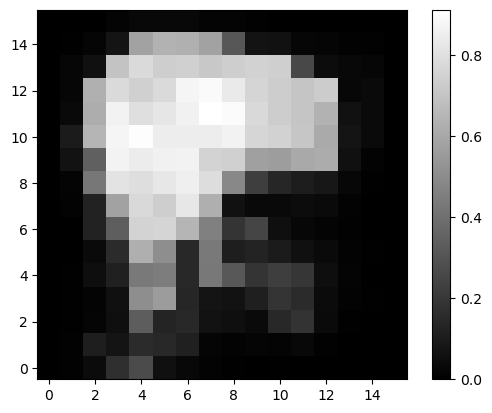

PREDICTED


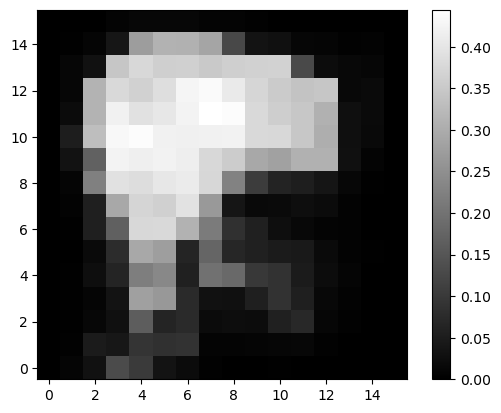

DIFFERENCE


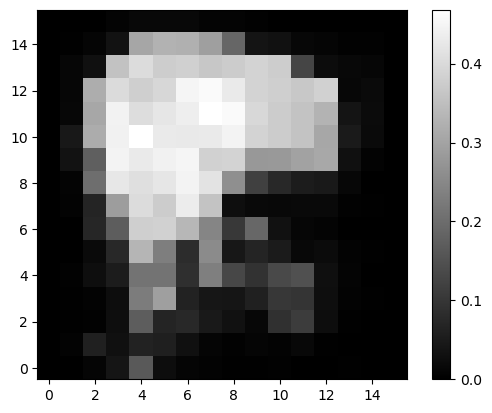

In [58]:
get_scan_slices(
        delta=False,
        dt=4,
        sub='04',
        coef=4,
        alpha=1e5,
        scan_number=180,
        dim=0,
        slice_number=4)

## Предсказание разницы между снимками

In [59]:
# ----------------------------------------------------------------
# Восстановление разницы между снимками фМРТ по одному изображению
# ----------------------------------------------------------------
# dt - гиперпараметр, время задержки
# sub - номер испытуемого
# coef - во сколько раз сжимается снимок фМРТ
# alpha - коэффициент регуляризации
# -------------------------------------------
def sub_linear_delta_prediction(dt=4, sub='04', coef=8, alpha=0):
    nu = 25 # частота видео
    mu = 641. / 390. # частота снимков фМРТ
    m, n, k = 40, 64, 64 # размерности снимка фМРТ до сжатия
    d = 2048 # длина вектора признакового описания изображения
    N = 641 - int(mu * dt) # N - количество снимков fMRI

    # (номер изображения, номер снимка)
    pairs = [(int(m * nu / mu), int(mu * dt + m)) for m in range(N)]

    # тензор снимка фМРТ
    sub_tensor = get_sub_tensor(sub)
    
    # сжатие снимка фМРТ
    if (coef > 1):
        maxpool = torch.nn.MaxPool3d(kernel_size=coef, stride=coef)
        input_tensor = sub_tensor.permute(3, 0, 1, 2)
        output_tensor = maxpool(input_tensor).permute(1, 2, 3, 0)
    else:
        output_tensor = sub_tensor

    d1, d2, d3, d4 = output_tensor.shape

    # список тензоров снимков фМРТ
    scans_list = [output_tensor[:, :, :, i] for i in range(d4)]

    # список снимков фМРТ, развернутых в векторы
    voxels = [scan.reshape(d1 * d2 * d3).numpy() for scan in scans_list]

    # (изображение, снимок)
    data = [(vector_list[n], voxels[k]) for n, k in pairs]

    # train, test
    l = int(0.7 * d4)
    train, test = data[:l], data[l:]

    #preprocessing
    def preprocess(v):
        return (v - v.min()) / (v.max() - v.min())
     
    train = [(pair[0], preprocess(pair[1])) for pair in train]
    test = [(pair[0], preprocess(pair[1])) for pair in test]
    
    delta_train = [(train[n][0], train[n][1] - train[n-1][1]) for n in range(1, len(train))]
    delta_test = [(test[n][0], test[n][1] - test[n-1][1]) for n in range(1, len(test))]
    
    Y_train = np.array([pair[1] for pair in train]).T
    Y_test = np.array([pair[1] for pair in test]).T
    
    # матрица весов модели
    W = []
    # Y - это изменение фМРТ снимка во времени
    X_train = np.array([pair[0] for pair in delta_train])
    deltaY_train = np.array([pair[1] for pair in delta_train]).T
    X_test = np.array([pair[0] for pair in delta_test])
    deltaY_test = np.array([pair[1] for pair in delta_test]).T

    if (alpha > 0):
        A = np.linalg.inv(X_train.T @ X_train + alpha * np.identity(X_train.shape[1])) @ X_train.T
    else:
        A = np.linalg.pinv(X_train)
    
    for i in range(d1 * d2 * d3):
        deltaY_train_vector = deltaY_train[i]
        w = A @ deltaY_train_vector
        W.append(w)
        
    # w будут строками    
    W = np.array(W)

    deltaY_train_predicted = W @ X_train.T
    deltaY_test_predicted = W @ X_test.T
    Y_train_predicted = np.delete(Y_train, -1, 1) + deltaY_train_predicted
    Y_test_predicted = np.delete(Y_test, -1, 1) + deltaY_test_predicted
    
    # усреднение по всем столбцам (снимкам фМРТ)
    def MSE(A):
        m, n = A.shape
        return 1 / n * np.linalg.norm(A, "fro") ** 2

    MSE_train = MSE(Y_train_predicted - np.delete(Y_train, 0, 1))
    MSE_test = MSE(Y_test_predicted - np.delete(Y_test, 0, 1))

    # сохранение выхода в файл
    output = np.array([MSE_train, MSE_test, Y_test.T[0], np.delete(Y_test, 0, 1), Y_test_predicted, deltaY_test_predicted, d1, d2, d3], dtype=object)
    output_name = f"output-{dt}-{sub}-{coef}"
    if (alpha > 0):
        output_name = output_name + f"-reg-{alpha}"
    folder_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "src", 'subs_delta', f"sub-{sub}")
    output_name = os.path.join(folder_path, output_name)
    np.save(output_name, output, allow_pickle=True)

    return output

In [89]:
def get_delta_model_result(dt=4, sub='04', coef=4, alpha=0):
    output_name = f"output-{dt}-{sub}-{coef}"
    if (alpha > 0):
        output_name = output_name + f"-reg-{alpha}.npy"
    folder_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "src", 'subs_delta', f"sub-{sub}")
    output_name = os.path.join(folder_path, output_name)
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
    if not os.path.exists(output_name):
        output = sub_linear_delta_prediction(dt, sub, coef, alpha)
    else:
        output = np.load(output_name, allow_pickle=True)
        
    return output

In [90]:
%%time
output = get_delta_model_result(dt=5, sub='04', coef=1, alpha = 1000)
    train, MSE_test, Y_test_0, Y_test, Y_test_predicted, deltaY_test_predicted, d1, d2, d3 = output
print(f"MSE_train = {MSE_train:.2f}, MSE_test = {MSE_test:.2f}")

MSE_train = 20.47, MSE_test = 17.84
CPU times: total: 234 ms
Wall time: 249 ms


### Предсказание последнего снимка по первому:

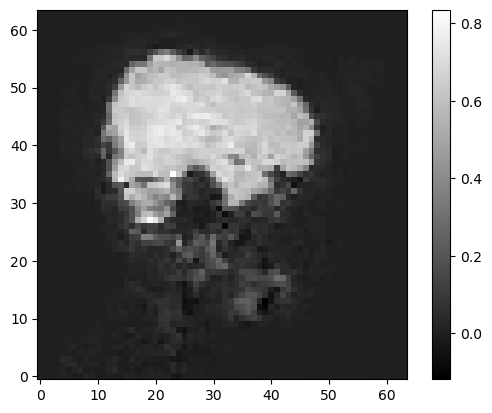

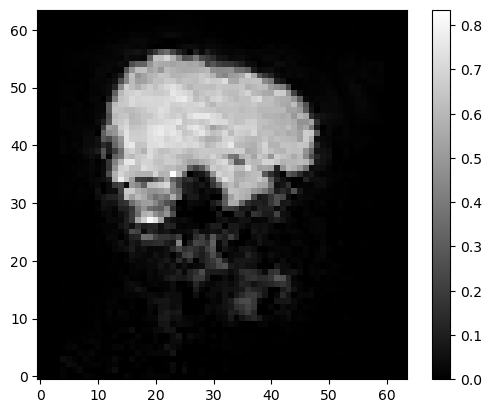

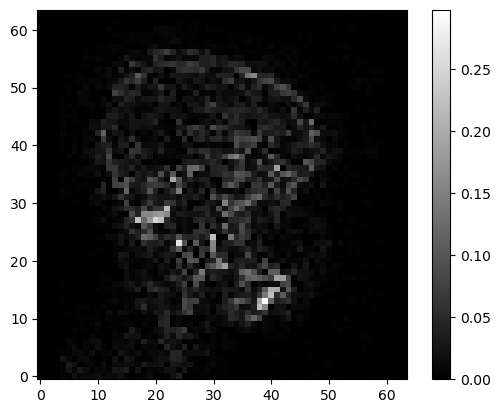

0.04974365234375

In [81]:
Y_last = Y_test_0 + np.sum(deltaY_test_predicted, axis = 1)
fmri_last_true = Y_test.T[-1].reshape((d1, d2, d3))
fmri_last = Y_last.reshape((d1, d2, d3))
mask = fmri_last < 0
fmri_last_prun = np.zeros_like(fmri_last)
fmri_last_prun[~mask] = fmri_last[~mask]
plt.imshow(fmri_last[10, :, :].T, cmap="gray", origin="lower")
plt.colorbar()
plt.show()

plt.imshow(fmri_last_prun[10, :, :].T, cmap="gray", origin="lower")
plt.colorbar()
plt.show()

delta = abs(fmri_last - fmri_last_true)
plt.imshow(delta[10, :, :].T, cmap="gray", origin="lower")
plt.colorbar()
plt.show()

np.sum(delta > 0.07) / np.sum(delta == delta)

INFORMATION:
dt = 5, sub = 04, coef = 8, slices = [4, ':', ':']

ORIGINAL


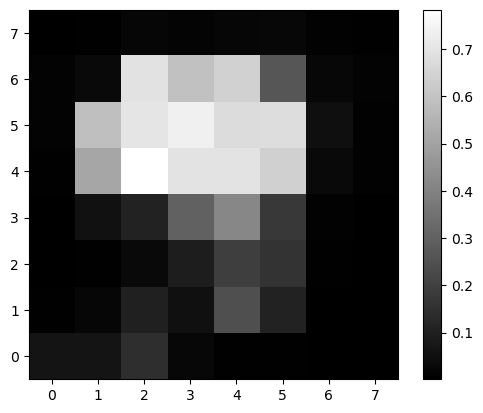

PREDICTED


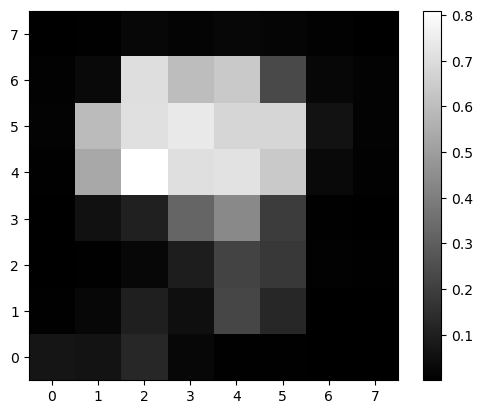

DIFFERENCE


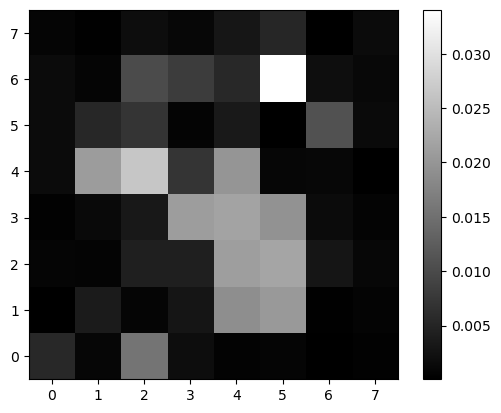

In [62]:
get_scan_slices(
        delta=True,
        dt=5,
        alpha=100,
        sub='04',
        coef=8,
        scan_number=-1,
        dim=0,
        slice_number=4)

## Восстановление k-го снимка по первому

In [193]:
def scan_recovering(k=-1, dt=4, sub='04', coef=2, alpha=1000):
    output = get_delta_model_result(dt, sub, coef, alpha)
    MSE_train, MSE_test, Y_test_0, Y_test, Y_test_predicted, deltaY_test_predicted, d1, d2, d3 = output
    Y = Y_test_0 + np.sum(deltaY_test_predicted.T[:k], axis = 0)
    if (k == -1):
        Y_true = Y_test.T[k].reshape((d1, d2, d3))
    else:
        Y_true = Y_test.T[k+1].reshape((d1, d2, d3))
    
    scan = Y.reshape((d1, d2, d3))
    scan_true = Y_true.reshape((d1, d2, d3))
    mask = scan < 0
    scan_prun = np.zeros_like(scan)
    scan_prun[~mask] = scan[~mask]

    print("PREDICTED")
    plt.imshow(scan[:, 16, :].T, cmap="gray", origin="lower")
    plt.colorbar()
    plt.show()

    print("ORIGINAL")
    plt.imshow(scan_true[:, 16, :].T, cmap="gray", origin="lower")
    plt.colorbar()
    plt.show()

    print("PRUNING")
    plt.imshow(scan_prun[:, 16, :].T, cmap="gray", origin="lower")
    plt.colorbar()
    plt.show()

    delta = abs(scan - scan_true)
    print("DELTA")
    plt.imshow(delta[:, 16, :].T, cmap="gray", origin="lower")
    plt.colorbar()
    plt.show()

PREDICTED


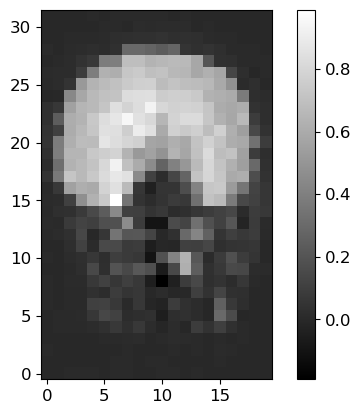

ORIGINAL


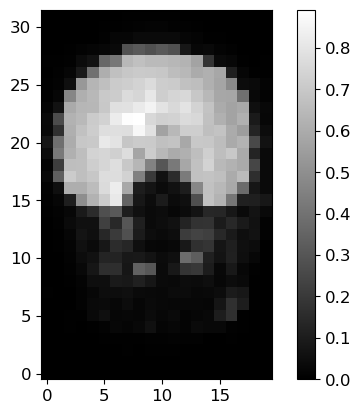

PRUNING


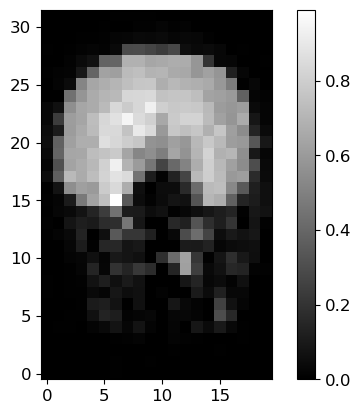

DELTA


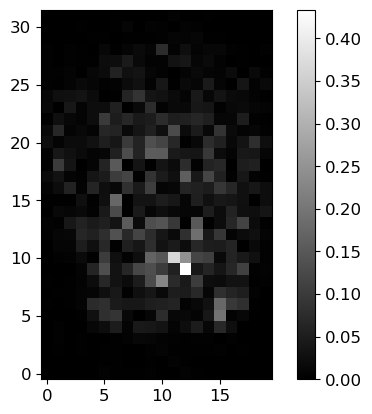

In [194]:
scan_recovering(k=-1)

In [ ]:
Y_last = Y_test_0 + np.sum(deltaY_test_predicted, axis = 1)
fmri_last_true = Y_test.T[-1].reshape((d1, d2, d3))
fmri_last = Y_last.reshape((d1, d2, d3))
mask = fmri_last < 0
fmri_last_prun = np.zeros_like(fmri_last)
fmri_last_prun[~mask] = fmri_last[~mask]
plt.imshow(fmri_last[10, :, :].T, cmap="gray", origin="lower")
plt.colorbar()
plt.show()

plt.imshow(fmri_last_prun[10, :, :].T, cmap="gray", origin="lower")
plt.colorbar()
plt.show()

delta = abs(fmri_last - fmri_last_true)
plt.imshow(delta[10, :, :].T, cmap="gray", origin="lower")
plt.colorbar()
plt.show()

np.sum(delta > 0.07) / np.sum(delta == delta)

## Графики зависимостей

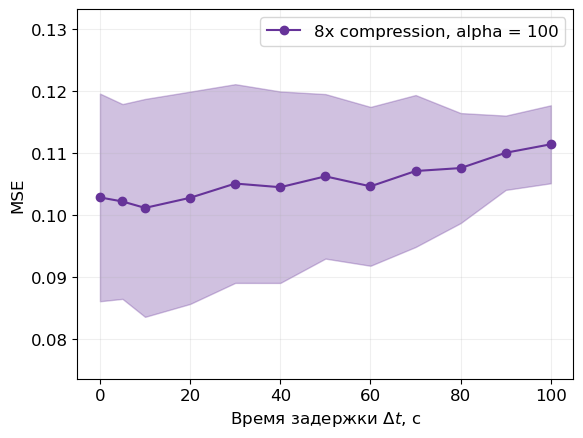

In [113]:
t = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#t = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]
mse_matrix = []

for sub in subs_with_fmri[:3]:
    mse = []

    for dt in t:
        output = get_delta_model_result(dt=dt, sub=sub, coef=8, alpha=100)
        MSE_test = output[1]
        mse.append(MSE_test)
    
    mse_matrix.append(mse)

mse_matrix = np.array(mse_matrix)
mse_means = np.array([vector.mean() for vector in mse_matrix.T])
mse_stds = np.array([vector.std() for vector in mse_matrix.T])

plt.rcParams.update({'font.size': 12})
plt.rc("font", family='sans-serif')

plt.plot(t, mse_means, marker='o', color="rebeccapurple", label="8x compression, alpha = 100")
plt.fill_between(t, mse_means - mse_stds, mse_means + mse_stds, color="rebeccapurple", alpha = 0.3)
plt.xlabel("Время задержки $\Delta t$, с")
plt.ylabel("MSE")
plt.ylim(0.7 * abs(mse_means - mse_stds).max(), 1.1 * abs(mse_means + mse_stds).max())
plt.legend()
plt.grid(alpha=0.2)

plt.savefig(os.path.join(figures, "subs_MSE_dt_100.pdf"), bbox_inches="tight")

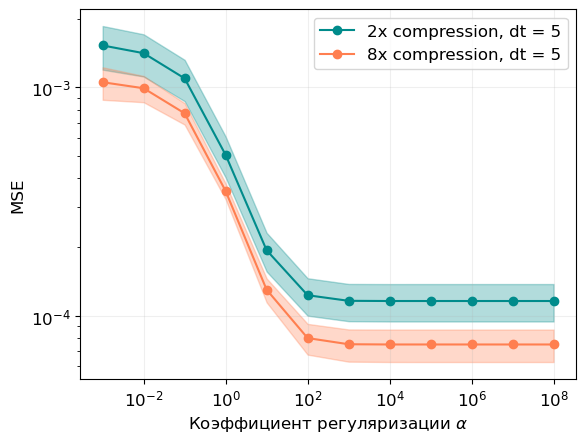

In [144]:
alphas = np.logspace(-3, 8, 12)
mse_matrix = []
mse_1_matrix = []

for sub in subs_with_fmri[:3]:
    mse = []
    mse_1 = []

    for alpha in alphas:
        output = get_delta_model_result(dt=5, sub=sub, coef=2, alpha=alpha)
        MSE_test = output[1] / 20480
        mse.append(MSE_test)
        output = get_delta_model_result(dt=5, sub=sub, coef=8, alpha=alpha)
        MSE_test = output[1] / 1280
        mse_1.append(MSE_test)
    
    mse_matrix.append(mse)
    mse_1_matrix.append(mse_1)

mse_matrix = np.array(mse_matrix)
mse_1_matrix = np.array(mse_1_matrix)

mse_means = np.array([vector.mean() for vector in mse_matrix.T])
mse_stds = np.array([vector.std() for vector in mse_matrix.T])

mse_1_means = np.array([vector.mean() for vector in mse_1_matrix.T])
mse_1_stds = np.array([vector.std() for vector in mse_1_matrix.T])

plt.rcParams.update({'font.size': 12})
plt.rc("font", family='sans-serif')

plt.plot(alphas, mse_means, marker='o', color="darkcyan", label="2x compression, dt = 5")
plt.fill_between(alphas, mse_means - mse_stds, mse_means + mse_stds, color="darkcyan", alpha = 0.3)
plt.plot(alphas, mse_1_means, marker='o', color="coral", label="8x compression, dt = 5")
plt.fill_between(alphas, mse_1_means - mse_1_stds, mse_1_means + mse_1_stds, color="coral", alpha = 0.3)
plt.xlabel("Коэффициент регуляризации $\\alpha$")
plt.ylabel("MSE")
#plt.ylim(0.7 * abs(mse_means - mse_stds).max(), 1.1 * abs(mse_means + mse_stds).max())
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(alpha=0.2)

plt.savefig(os.path.join(figures, "subs_MSE_dt_alpha.pdf"), bbox_inches="tight")